# Football Analytics for MchezoPesa

You have been recruited as a football analyst in a company - Mchezopesa Ltd and tasked to accomplish the task below.

A prediction result of a game between team 1 and team 2, based on who's home and who's away, and on whether or not the game is friendly (include rank in your training).

# Understanding the data

In [188]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import scipy.stats as stats
from sklearn.decomposition import PCA

In [131]:
fifa_rank = pd.read_csv("fifa_ranking.csv")
results = pd.read_csv("results.csv")

In [132]:
fifa_rank.head(5)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [133]:
fifa_rank.shape

(57793, 16)

In [134]:
results.shape

(40839, 9)

In [135]:
results.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


# Data Cleaning

In [136]:
#Data Completeness
fifa_rank.isnull().sum()

rank                       0
country_full               0
country_abrv               0
total_points               0
previous_points            0
rank_change                0
cur_year_avg               0
cur_year_avg_weighted      0
last_year_avg              0
last_year_avg_weighted     0
two_year_ago_avg           0
two_year_ago_weighted      0
three_year_ago_avg         0
three_year_ago_weighted    0
confederation              0
rank_date                  0
dtype: int64

In [137]:
#Data Completeness
results.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [138]:
#Data Consistency
fifa_rank.duplicated().sum()

37

In [139]:
fifa_rank.drop_duplicates(keep=False,inplace=True)

In [140]:
#Data Consistency
results.duplicated().sum()

0

In [141]:
#Dropping Variables that wont be necessary in this research
fifa_rank.drop(['country_abrv', 'cur_year_avg', 'cur_year_avg_weighted', 
           'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg', 
           'two_year_ago_weighted', 'three_year_ago_avg', 'three_year_ago_weighted', 
           'total_points', 'previous_points'],inplace= True, axis=1)    

In [142]:
results.drop(['city'], inplace=True, axis=1)

# Merging the DataSets

Merging by the Date columns

In [143]:
fifa_rank.dtypes

rank              int64
country_full     object
rank_change       int64
confederation    object
rank_date        object
dtype: object

In [144]:
results.dtypes

date          object
home_team     object
away_team     object
home_score     int64
away_score     int64
tournament    object
country       object
neutral         bool
dtype: object

In [145]:
#Converting Date columns to Datetime
results['date']= pd.to_datetime(results['date'])
fifa_rank['rank_date']= pd.to_datetime(fifa_rank['rank_date'])

In [146]:
fifa_rank.dtypes

rank                      int64
country_full             object
rank_change               int64
confederation            object
rank_date        datetime64[ns]
dtype: object

In [147]:
results.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
country               object
neutral                 bool
dtype: object

In [148]:
#Extracting year and months from the date column
fifa_rank['year'] = fifa_rank.rank_date.dt.year
fifa_rank['month'] = fifa_rank.rank_date.dt.month

In [149]:
results['year'] = results.date.dt.year
results['month'] = results.date.dt.month

In [150]:
fifa_rank.head(3)

,rank,country_full,rank_change,confederation,rank_date,year,month
0,1,Germany,0,UEFA,1993-08-08,1993,8
1,2,Italy,0,UEFA,1993-08-08,1993,8
2,3,Switzerland,9,UEFA,1993-08-08,1993,8


In [151]:
results.head(3)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,year,month
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,False,1872,11
1,1873-03-08,England,Scotland,4,2,Friendly,England,False,1873,3
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,False,1874,3


In [152]:
#Filtering data to have data >= 1993
results = results[results['year']>=1993]

In [153]:
results.head(3)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,year,month
17361,1993-01-01,Ghana,Mali,1,1,Friendly,Gabon,True,1993,1
17362,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Gabon,False,1993,1
17363,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait,False,1993,1


In [154]:
#Merging Home Team Datasets
# Merging to get Home dataset

Home_df = pd.merge(fifa_rank, results, how = 'inner', left_on = ['year', 'month','country_full'], 
                     right_on = ['year', 'month','home_team'])

In [155]:
# Merging away team datasets
Away_df = pd.merge(fifa_rank, results, how = 'inner', left_on = ['year', 'month','country_full'], 
                     right_on = ['year', 'month','away_team'])

In [156]:
Home_df.head(5)

,rank,country_full,rank_change,confederation,rank_date,year,month,date,home_team,away_team,home_score,away_score,tournament,country,neutral
0,4,Sweden,0,UEFA,1993-08-08,1993,8,1993-08-11,Sweden,Switzerland,1,2,Friendly,Sweden,False
1,4,Sweden,0,UEFA,1993-08-08,1993,8,1993-08-22,Sweden,France,1,1,FIFA World Cup qualification,Sweden,False
2,5,Argentina,5,CONMEBOL,1993-08-08,1993,8,1993-08-22,Argentina,Peru,2,1,FIFA World Cup qualification,Argentina,False
3,5,Argentina,5,CONMEBOL,1993-08-08,1993,8,1993-08-29,Argentina,Paraguay,0,0,FIFA World Cup qualification,Argentina,False
4,8,Brazil,-5,CONMEBOL,1993-08-08,1993,8,1993-08-08,Brazil,Mexico,1,1,Friendly,Brazil,False


In [157]:
Away_df.head(5)

,rank,country_full,rank_change,confederation,rank_date,year,month,date,home_team,away_team,home_score,away_score,tournament,country,neutral
0,3,Switzerland,9,UEFA,1993-08-08,1993,8,1993-08-11,Sweden,Switzerland,1,2,Friendly,Sweden,False
1,5,Argentina,5,CONMEBOL,1993-08-08,1993,8,1993-08-01,Peru,Argentina,0,1,FIFA World Cup qualification,Peru,False
2,5,Argentina,5,CONMEBOL,1993-08-08,1993,8,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Paraguay,False
3,5,Argentina,5,CONMEBOL,1993-08-08,1993,8,1993-08-15,Colombia,Argentina,2,1,FIFA World Cup qualification,Colombia,False
4,8,Brazil,-5,CONMEBOL,1993-08-08,1993,8,1993-08-01,Venezuela,Brazil,1,5,FIFA World Cup qualification,Venezuela,False


In [158]:
#Renaming Rank columns to be able to differentiate them while merging.
Away_df.rank = Away_df.rename({'rank': 'away_rank'}, axis = 1, inplace = True)
Home_df.rank = Home_df.rename({'rank': 'home_rank'}, axis = 1, inplace = True)

In [159]:
#Dropping Most Columns in Away df and remaining with information about away team only
Away_df.drop(['country_full', 'confederation', 'rank_date', 
           'date', 'home_team', 'home_score', 
           'tournament', 'country', 'neutral', 
           ],inplace= True, axis=1)

In [160]:
Away_df.head(5)

,away_rank,rank_change,year,month,away_team,away_score
0,3,9,1993,8,Switzerland,2
1,5,5,1993,8,Argentina,1
2,5,5,1993,8,Argentina,3
3,5,5,1993,8,Argentina,1
4,8,-5,1993,8,Brazil,5


In [161]:
#Merging Home and away Datasets
fifa_rankings_df = pd.merge(Home_df, Away_df, how = 'inner', left_on = ['year', 'month','away_team'], 
                     right_on = ['year', 'month','away_team'])

In [162]:
#Previewing Merged Dataset
fifa_rankings_df.head(5)

,home_rank,country_full,rank_change_x,confederation,rank_date,year,month,date,home_team,away_team,home_score,away_score_x,tournament,country,neutral,away_rank,rank_change_y,away_score_y
0,4,Sweden,0,UEFA,1993-08-08,1993,8,1993-08-11,Sweden,Switzerland,1,2,Friendly,Sweden,False,3,9,2
1,4,Sweden,0,UEFA,1993-08-08,1993,8,1993-08-22,Sweden,France,1,1,FIFA World Cup qualification,Sweden,False,12,7,1
2,5,Argentina,5,CONMEBOL,1993-08-08,1993,8,1993-08-22,Argentina,Peru,2,1,FIFA World Cup qualification,Argentina,False,70,8,1
3,5,Argentina,5,CONMEBOL,1993-08-08,1993,8,1993-08-22,Argentina,Peru,2,1,FIFA World Cup qualification,Argentina,False,70,8,1
4,5,Argentina,5,CONMEBOL,1993-08-08,1993,8,1993-08-22,Argentina,Peru,2,1,FIFA World Cup qualification,Argentina,False,70,8,0


In [163]:
#checking for missing values and duplicates on the merged dataset
fifa_rankings_df.isnull().sum()

home_rank        0
country_full     0
rank_change_x    0
confederation    0
rank_date        0
year             0
month            0
date             0
home_team        0
away_team        0
home_score       0
away_score_x     0
tournament       0
country          0
neutral          0
away_rank        0
rank_change_y    0
away_score_y     0
dtype: int64

In [164]:
fifa_rankings_df.duplicated().sum()

4497

In [165]:
#Dropping Duplicates
fifa_rankings_df.drop_duplicates(keep=False,inplace=True)

In [166]:
#Dropping columns to remain with the necessary ones for the model
fifa_rankings_df.drop(['country','date','away_score_y','rank_change_y','away_score_y','rank_change_x','rank_date'], inplace=True, axis=1)

In [167]:
fifa_rankings_df.head(5)

,home_rank,country_full,confederation,year,month,home_team,away_team,home_score,away_score_x,tournament,neutral,away_rank
0,4,Sweden,UEFA,1993,8,Sweden,Switzerland,1,2,Friendly,False,3
1,4,Sweden,UEFA,1993,8,Sweden,France,1,1,FIFA World Cup qualification,False,12
4,5,Argentina,CONMEBOL,1993,8,Argentina,Peru,2,1,FIFA World Cup qualification,False,70
7,19,Colombia,CONMEBOL,1993,8,Colombia,Peru,4,0,FIFA World Cup qualification,False,70
10,67,Paraguay,CONMEBOL,1993,8,Paraguay,Peru,2,1,FIFA World Cup qualification,False,70


In [168]:
#renaming away score X
fifa_rankings_df.away_score_x = fifa_rankings_df.rename({'away_score_x': 'away_score'}, axis = 1, inplace = True)

# Logistic Regression

In [181]:
#Libraries
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

Predict whether a team will Win or lose

In [169]:
#Creating a new column for win, lose or Draw from the home Team's Perspective.
fifa_rankings_df['Home Score'] = fifa_rankings_df['home_score'] - fifa_rankings_df['away_score']
def homescore(home_score):
    if home_score > 0:
        return 'Win'
    elif home_score < 0:
        return 'Loss'
    else:
        return 'Draw'
      
fifa_rankings_df['Status'] = fifa_rankings_df['Home Score'].apply(lambda h: homescore(h))
fifa_rankings_df.head(5)

,home_rank,country_full,confederation,year,month,home_team,away_team,home_score,away_score,tournament,neutral,away_rank,Home Score,Status
0,4,Sweden,UEFA,1993,8,Sweden,Switzerland,1,2,Friendly,False,3,-1,Loss
1,4,Sweden,UEFA,1993,8,Sweden,France,1,1,FIFA World Cup qualification,False,12,0,Draw
4,5,Argentina,CONMEBOL,1993,8,Argentina,Peru,2,1,FIFA World Cup qualification,False,70,1,Win
7,19,Colombia,CONMEBOL,1993,8,Colombia,Peru,4,0,FIFA World Cup qualification,False,70,4,Win
10,67,Paraguay,CONMEBOL,1993,8,Paraguay,Peru,2,1,FIFA World Cup qualification,False,70,1,Win


In [170]:
# Splitting our dataset
#
X = fifa_rankings_df.drop("Status",axis=1)
y = fifa_rankings_df["Status"]

In [171]:
#Encoding categorical variables

X = pd.get_dummies(X, drop_first=True)

In [172]:
#Splitting the data without biases
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [173]:
# Fitting the model
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [174]:
# Using our model to make a prediction
#
y_pred = LogReg.predict(X_test)

In [175]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[1379,    4,    0],
       [   0, 1887,    0],
       [   0,    0, 2748]], dtype=int64)

In [177]:
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix
accuracy_score(y_test, y_pred)

0.9993353273512795

# Polynomial Regression

Predicting how many goals the home team scores


In [178]:
#Splitting dataset and havinh home score as Y
X = fifa_rankings_df.drop("home_score",axis=1)
y = fifa_rankings_df["home_score"]

In [179]:
# converting categorical variables into dummy indicators
X = pd.get_dummies(X, drop_first=True)

In [182]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Standardising X_train and X_test 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Fitting the polynomial features to X_train and X_test
poly_features = PolynomialFeatures(degree = 1)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

# Training the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)


# Making predictions
y_pred = regressor.predict(X_test)

# Accuracy of the model
print("The RMSE score for the model : ", np.sqrt(mean_squared_error(y_test, y_pred)))

The RMSE score for the model :  7.994997867599129e-15


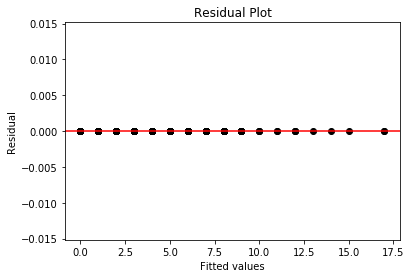

In [183]:
# Bartlett's test

residuals = y_pred - y_test

# Plotting the prediction errors
plt.scatter(y_pred, residuals, color='black')
plt.title('Residual Plot')
plt.ylabel('Residual')
plt.xlabel('Fitted values')
plt.axhline(y= residuals.mean(), color='red')
plt.show()

Predicting how many goals the home team scores

In [184]:
#Splitting dataset and having away score as Y
X = fifa_rankings_df.drop("away_score",axis=1)
y = fifa_rankings_df["away_score"]

In [185]:
# Converting categorical variables into dummy indicators
X = pd.get_dummies(X, drop_first=True)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Standardising X_train and X_test to the same scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Fitting the polynomial features to X_train and X_test
poly_features = PolynomialFeatures(degree = 1)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

# Training the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Making predictions
y_pred = regressor.predict(X_test)

# Measuring the accuracy of the model
print("The RMSE score for the model : ", np.sqrt(mean_squared_error(y_test, y_pred)))

The RMSE score for the model :  8.369942588334564e-15


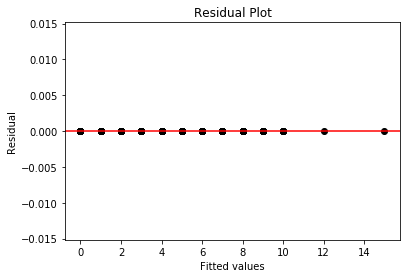

In [187]:
# Bartlett's test

residuals = y_pred - y_test

# Plotting the prediction errors

plt.scatter(y_pred, residuals, color='black')
plt.title('Residual Plot')
plt.ylabel('Residual')
plt.xlabel('Fitted values')
plt.axhline(y= residuals.mean(), color='red')
plt.show()